In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import mltools

In [2]:
class LSTMCSCModel(nn.Module):
    '''循环神经网络分类模型'''

    def __init__(self, *args, tokenizer_size, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.tokenizer_size = tokenizer_size  # 词汇表大小
        self.hidden_layer = nn.LSTM(self.tokenizer_size, hidden_size=512, batch_first=True, bidirectional=True)  # 定义隐藏层
        self.output_layer = nn.Linear(512 * 2, 2)  # 定义输出层

    def forward(self, x, state=None):
        '''前向传播'''
        x = F.one_hot(x, self.tokenizer_size)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = x.to(torch.float32)
        x, state = self.hidden_layer(x, state)  # x形状为(批量大小, 时间步数, 隐藏大小), state形状为(隐藏层数 * directions, 批量大小, 隐藏大小)
        x = x.mean(dim=1)  # 在时间步数维度取平均, x形状为(批量大小, 隐藏大小)
        x = self.output_layer(x)  # 它的输出形状是(批量大小, 输出大小)
        return x, state

In [3]:
class LSTMCSC(mltools.MachineLearning):
    '''RNN 文本分类学习'''

    @mltools.MachineLearning.trainer
    def train(self, num_epochs):
        '''迭代训练'''
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = self.tokenizer(x)
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train, _ = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = self.tokenizer(x)
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val, _ = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data)  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    @mltools.MachineLearning.tester
    def test(self):
        '''测试模型'''
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = self.tokenizer(x)
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test, _ = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    @mltools.MachineLearning.predictor
    def predict(self):
        '''预测模型'''
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x, y = x[:10], y[:10]
        X = self.tokenizer(x)
        X = X.to(self.device)
        y = y.to(self.device)
        y_pred, _ = self.model(X)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        for content, pred, real in zip(x, y_pred, y):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {content}')

In [4]:
train_iter, val_iter, test_iter, tokenizer = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')  # 加载词表，数据集


def tokenize(text):
    return tokenizer(text, max_length=200)


model = LSTMCSCModel(tokenizer_size=len(tokenizer))  # 定义训练模型
loss = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.SGD(model.parameters(), lr=1e-1)  # 设置优化器
legend = ['train loss', 'val loss', 'val acc']  # 设置图例
device = torch.device('cuda')  # 设置设备
ml = LSTMCSC(train_iter, val_iter, test_iter, tokenizer=tokenize, model=model, loss=loss, optimizer=optimizer, legend=legend, device=device)

2025-06-15 12:59:28,393 - INFO: train loss 0.608, val loss 0.605, val acc 0.692, 34.6 sec/epoch on cuda


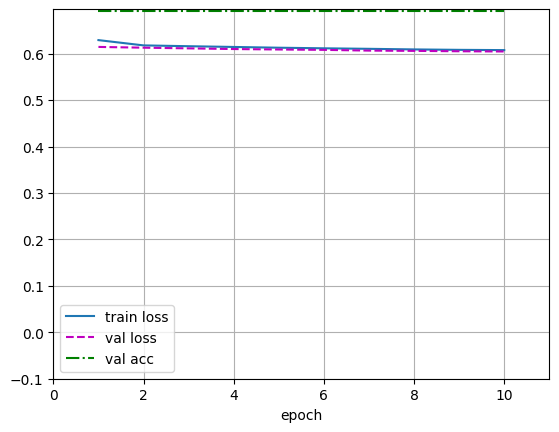

In [5]:
ml.train(num_epochs=10)  # 训练

In [6]:
ml.test()  # 测试

2025-06-15 12:59:32,482 - INFO: test acc 0.674


In [7]:
ml.predict()  # 预测

预测值 1, 真实值 0, 数据 没见过这么差的四星酒店!建议大家以后千万别住,离银滩很远很远!环境也很一般,服务就差得没法提了!
预测值 1, 真实值 1, 数据 这次春节去金华玩在国贸住了一天，总体感觉是很不错的，宾馆的硬件和服务都很好。就是住宿停车要收费的，虽然收费不高，但是感觉别扭，这个好象是金华宾馆的通病。还有，早餐是88元的，好象是偏高了，并不值。
预测值 1, 真实值 1, 数据 海上花园酒店紧邻菽庄花园，离商业街龙头路也不远，位置得天独厚。傍晚上岛，乘坐酒店免费接送游客的电瓶车，我们沿着环岛路绕行鼓浪屿一周。迎着海风，岛上的景致惊鸿一瞥，锦缎似的蓝色海面好似一个温柔的怀抱，令夕阳一点一点地沉睡下去…海上花园酒店的1201标间正对一宽大的平台，推门即可见美丽的院景和无边的海景。每晚，在鼓浪屿音乐厅欣赏完免费的音乐演出，从月色如水的寂静小巷回到灯火阑珊的海上花园酒店，温暖闲逸的度假生活令人满心欢喜。
预测值 1, 真实值 1, 数据 酒店服务很好，床很舒服，也许是比较喜欢西餐的原因，个人比较喜欢万豪的早餐，交通方便，因为去香港两天都在下雨，显得尤为重要，楼下通太古广场和地铁，大半时间都在太古逛了，还顺便看了一场电影，从LG去地铁站坐地铁去尖沙咀和湾仔都只有一站，铜锣湾只有两站，以后再去还会考虑住这里
预测值 1, 真实值 0, 数据 房间陈旧,服务差,设备也陈旧.垃圾酒店!
预测值 1, 真实值 0, 数据 该酒店338元/标间价格绝对不值,不知道航空酒店定价标准是什么.马桶根本没有消毒,前天晚上入住,用了马桶之后,屁股立马骚痒,到现在还没有消退.另外,早餐餐厅也小得可怜,食物品种和数量也少,要是晚去吃早餐,保准吃不到.
预测值 1, 真实值 1, 数据 春节期间入住，房价稍高，但还算物有所值。酒店设施完善，房间干净整洁。服务员态度很好，工作热情。地理位置稍为不方便，到中央大街、冰雪大世界、太阳岛等景点打车约为10-20元人民币。从机场前往酒店可坐机场巴士到民航大厦(总站)，再打车约10分钟，10-15元人民币。
预测值 1, 真实值 0, 数据 房间设施陈旧，服务一般，由于中午到的酒店，网络调试需要帮助，居然说中午人都休息了，得等1点以后上班，靠。早餐还是很丰富的，下次不会住了，性价比不高。
预测值 1, 真实值 1, 数据 几乎是在凌晨才到的包头，包